In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import warnings

from sklearn.datasets import make_blobs, make_circles
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, zero_one_loss, confusion_matrix

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
dtrain = pd.read_csv('/home/volkov/hard_mnist/hard_train.txt', header = None, sep = '\\s+')
dlabels = pd.read_csv('/home/volkov/hard_mnist/hard_train_labels.txt', header = None, sep = '\\s+')

In [ ]:
X_test = dtrain[10000:11000]
y_test = dlabels[10000:11000]

Здесь реализована вспомогающая функция, а так же реализация запуск KNN на 20 соседях и пяти разных выборках.

In [4]:
def knn_algorithm(X_train, y_train, X_test, y_test, start=0, end=-1, **kargs):
    X_train = X_train[start:end]
    y_train = y_train[start:end]
    start = time.time()
    model = KNeighborsClassifier(**kargs)
    model.fit(X_train, y_train)
    fraction_misclassifications = zero_one_loss(y_test, model.predict(X_test))
    end = time.time()
    return(fraction_misclassifications, end-start)

In [17]:
f = open('knn1.txt', 'a')
for j in range(1, 6):
    for i in range(1, 21):
        error_with_time = knn_algorithm(dtrain, dlabels, X_test, y_test, end=2000*j, n_neighbors=i, algorithm='brute')
        f.write(str(i) + ' ' + ' '.join(map(str, error_with_time)) + '\n')
f.close()

Тут отрисовываем графики. Для этого создадим 2 функции, которые полуают на вход путь к файлу, а затем с учетом специфики созранненых данных извлекают их и возвращают объект plt.

In [66]:
def accuracy_drawer(file_path):
    f = pd.read_csv(file_path, header = None, sep = '\\s+')
    accuracy = 1 - np.array(f[:][0])
    k = range(1, 21)
    plt.figure(figsize=(14,8))
    plt.ylabel("accuracy", fontsize=15)
    plt.xlabel("k", fontsize=15)
    
    for i in range(5):
        plt.plot(k, accuracy[i*20:20*(i+1)])

    plt.legend(['size = 2000', 'size = 4000', 'size = 6000', 'size = 8000','size = 10000'], loc='down left')
    return(plt)


def time_drawer(file_path):
    f = pd.read_csv(file_path, header = None, sep = '\\s+')
    time = np.array(f[:][1])
    plt.figure(figsize=(14,8))
    plt.ylabel("time", fontsize=15)
    plt.xlabel("size of data set", fontsize=15)
    time_partition = [[time[20*i+j] for i in range(5)] for j in range(5)]
    size_of_data_set = [i*2000 for i in range(1, 6)]

    for i in range(5):
        plt.plot(size_of_data_set, time_partition[i])

    plt.legend(['k = 1', 'k = 2', 'k = 3', 'k = 4', 'k = 5'], loc='upper left')
    return(plt)

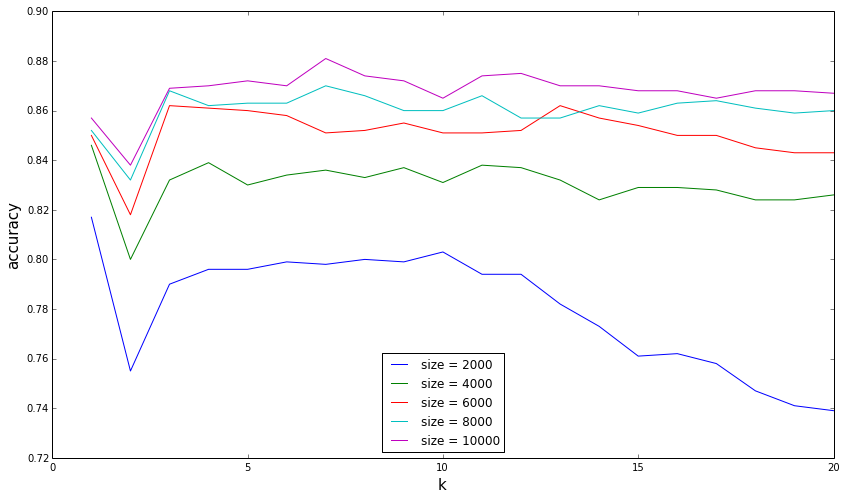

In [65]:
plt_accuracy = accuracy_drawer("knn1.txt")
plt_accuracy.show()

По данному графику видно, что при k = 2 ошибка при классификации самая  большая. Это объясняется тем, что по дефолту weights = 'uniform', то есть при запуске KNeighborsClassifier весам всех объектов предполаются одинаковыми. Это создает проблемы на границах классов. Когда два ближайших соседа из разных классов. 

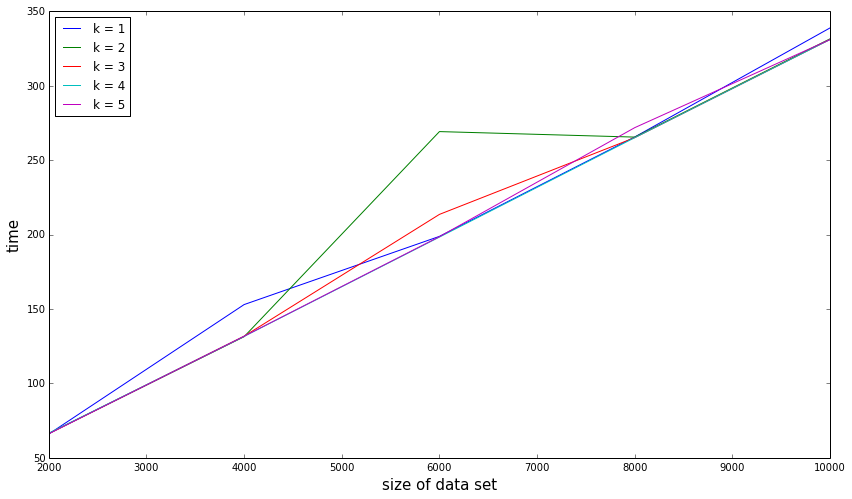

In [67]:
plt_time = time_drawer("knn1.txt")
plt_time.show()

Можно подумать над разными методами улучшения классификации. Например, найти самый оптимальный k, выходящий за пределы первых 20-и, используя LOO, так же можно попробовать поиграться с метрикой и использовать что-то другое, вместо евклидова расстояния. Кроме того, можно заняться отбором эталонов и отбросить часть шумовых элементов.

Далее попытаемся избавиться от шума новыми разбиениями на тестовую и обучающую выборки. И запуском knn_algorithm.

In [ ]:
step = 10000
for k in range(2, 5):
    X_test = dtrain[step*k:step*k+1000]
    y_test = dlabels[step*k:step*k+1000]
    result = []
    for j in range(1, 6):
        for i in range(1, 21):
            result.append(knn_algorithm(dtrain, dlabels, X_test, y_test, start=step*(k-1), 
                                            end=2000*j+step*(k-1), n_neighbors=i, algorithm='brute'))
    pd.DataFrame(result).to_csv('knn{}.txt'.format(k), sep=' ', index=False, header=False, mode='a')

    

Усредним полученные результаты.

In [15]:
average = np.array(pd.read_csv('knn1.txt', header = None, sep = '\\s+'))
average = average[:, 1:]
for data_set_number in range(2, 5):
    average += np.array(pd.read_csv('knn{}.txt'.format(data_set_number), header = None, sep = '\\s+'))
pd.DataFrame(average/5).to_csv('knn_average.txt', sep=' ', index=False, header=False, mode='a')


Во-первых сравнивая данный график с первым, не трудно заметить, что этот более сглаженный, и в отличие от первого графика, в котором шумы имели большое влиние, тут это отражается не так критично и, например, в данном случае кривые не пересекаются. Во-вторых, можно выделить наилучший результат в классификации(89.83%). Он достигается на 7NN.

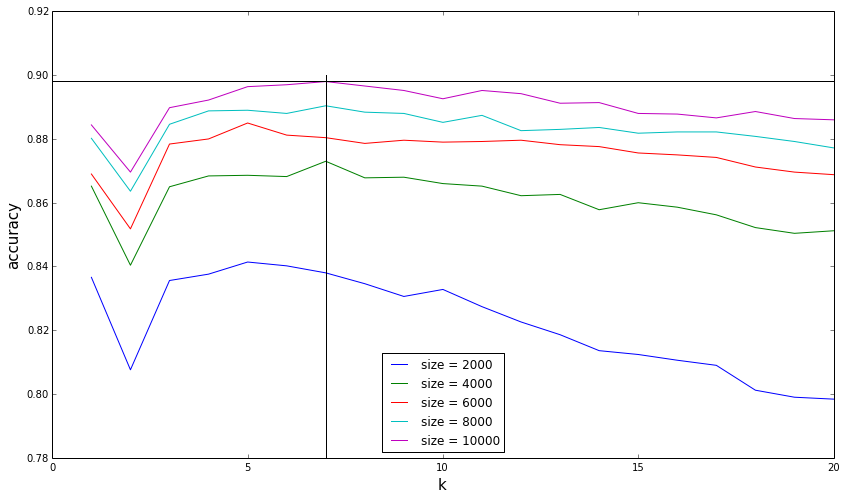

In [69]:
plt_accuracy = accuracy_drawer("knn_average.txt")
plt_accuracy.plot([7, 7], [0.78, 0.90], 'k-')
plt_accuracy.plot([0, 20], [0.8983, 0.8983], 'k-')
plt_accuracy.show()

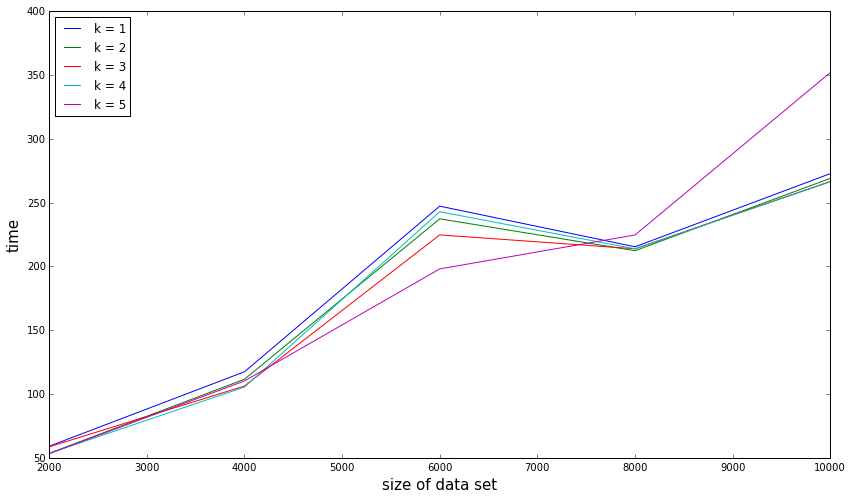

In [70]:
plt_time = time_drawer("knn_average.txt")
plt_time.show()

В заключительной части, данной лабораторной. Выберем лучшее 𝑘, обучим на нем kNN для самой большой
обучающей выборки и построим для него матрицу ошибок на тестовой выборке

In [ ]:
X_train = np.array(dtrain[:10000])
y_train = np.array(dlabels[:10000])

model = KNeighborsClassifier(n_neighbors=7, algorithm='brute')
model.fit(X_train, y_train)
pd.DataFrame(model.predict(X_test)).to_csv("7NN_predictions.txt", sep=' ', index=False, header=False, mode='a')

Здесь создадим функцию для отрисовывания матрицы ошибок. На вход она принимает путь к файлу с сырыми данными и затем создает матрицу ошибок и нормализует ее, а возвращает объект plt с визуализированной матрицей.

In [102]:
def error_normalized_matrix_plot(file_path):
    y_predicted = pd.read_csv(file_path, header = None, sep = '\\s+')
    error_matrix = confusion_matrix(y_test, y_predicted)
    em_normalized = cm.astype('float') / error_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(14,8))
    plt.ylabel("real labels", fontsize=12)
    plt.xlabel("predicted labels", fontsize=12)
    plt.title('Normalized Confusion Matrix', fontsize=15)
    plt.imshow(em_normalized, interpolation='none')
    return(plt)

По графику видно, что качество классификации довольно хорошее. Так как диагональные квадратики более красные, что говорит о том, что метки классов предсказаний и реальных ответов довольно хорошо совпадают.  

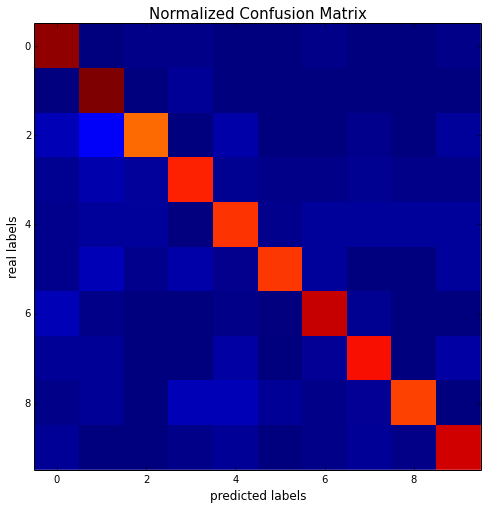

In [103]:
plt_matrix = error_normalized_matrix_plot("7NN_predictions.txt")
plt_matrix.show()